# <u>M</u>edical <u>D</u>eep <u>L</u>earning
## Exercise 3: Image Registration


## Preparation

The aim of this exercise is to introduce you to deep-learning based image registration.

At first we download the dataset and run the required imports:

In [ ]:
# download dataset
!wget https://cloud.imi.uni-luebeck.de/s/5ZojnpTRxfLCmYd/download -O mdl_exercise3_multimodal_reg.pth


--2022-05-18 13:30:47--  https://cloud.imi.uni-luebeck.de/s/5ZojnpTRxfLCmYd/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39324179 (38M) [application/octet-stream]
Saving to: ‘mdl_exercise3_multimodal_reg.pth’

mdl_exercise3_multi 100%[===================>]  37.50M  7.77MB/s    in 4.8s    

2022-05-18 13:30:54 (7.77 MB/s) - ‘mdl_exercise3_multimodal_reg.pth’ saved [39324179/39324179]



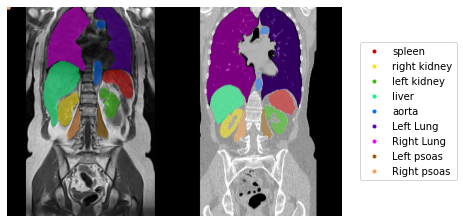

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
def gpu_usage():
    print('gpu usage (current/max): {:.2f} / {:.2f} GB'.format(torch.cuda.memory_allocated()*1e-9, torch.cuda.max_memory_allocated()*1e-9))

#load data which contains 8 pairs of 2D MR and CT slices with anatomical labels.
#The images are stored in the tensors, ct_img_all, mr_seg_all, etc.
#Please note that for the first task, there exists a pre-registered variant called ct_img_all_reg ..
data = torch.load('mdl_exercise3_multimodal_reg.pth')
locals().update(data)
### overlaySegment: returns RGB-overlay of given image and segmentation
def overlaySegment(gray1,segs1,colors):
    H, W = segs1.squeeze().size()
    C = colors.shape[0] 
    segs1_onehot = torch.zeros(size=(C,H,W)).to(segs1.device).scatter_(0, segs1.view(1,H,W), 1).detach()
    seg_color = torch.mm(segs1_onehot.view(C,-1).t(),colors).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(segs1_onehot[0,:,:]==0).float(),0,1.0)
    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    return overlay

## visualise two input scans
rgb = overlaySegment(torch.clamp(mr_img_all[3,0].permute(1,0).flip(0,1),0,700)/700,mr_seg_all[3,0].permute(1,0).flip(0,1),cdata.view(-1,3)/255)    
rgb2 = overlaySegment(torch.clamp(ct_img_all[3,0].permute(1,0).flip(0,1)+800,0,1200)/1200,ct_seg_all[3,0].permute(1,0).flip(0,1),cdata.view(-1,3)/255)    

plt.imshow(torch.cat((rgb,rgb2),1))
plt.axis('off')
for i in range(1,10):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs_wb[i-1])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

In [ ]:
cdata

tensor([[  0.,   0.,   0.],
        [208.,   0.,   0.],
        [255., 230.,   2.],
        [ 48., 194.,   0.],
        [  0., 255., 123.],
        [  0., 110., 255.],
        [ 98.,   0., 190.],
        [247.,   0., 255.],
        [158.,  97.,   0.],
        [255., 160.,  70.],
        [  0., 131.,  32.],
        [ 49., 165., 171.],
        [ 62.,  27., 203.],
        [107.,   0., 208.],
        [208.,   0.,   0.],
        [255., 230.,   2.],
        [ 48., 194.,   0.],
        [  0., 255., 123.],
        [  0., 110., 255.],
        [ 98.,   0., 190.],
        [247.,   0., 255.],
        [158.,  97.,   0.],
        [255., 160.,  70.],
        [  0., 131.,  32.],
        [ 49., 165., 171.],
        [ 62.,  27., 203.],
        [107.,   0., 208.]])

In [ ]:
cdata.shape

torch.Size([27, 3])

In [ ]:
rgb.shape

torch.Size([320, 256, 3])

In [ ]:
mr_img_all.shape

torch.Size([8, 1, 256, 320])

In [ ]:
ct_img_all.shape

torch.Size([8, 1, 256, 320])

In [ ]:
# utility functions to display a displacement field and compute the Dice overlap
from matplotlib import cm
from matplotlib import colors as mcolors
import numpy as np
def showFlow(def_x):
    x = def_x.squeeze().numpy()[0,:,:]
    y = def_x.squeeze().numpy()[1,:,:]
    #show flow map for numpy
    H, W = x.shape
    rho = np.sqrt(x*x+y*y)
    theta = np.arctan2(x,-y)
    theta2 = (-theta+np.pi)/(2.0*np.pi);
    rho = np.clip(rho/np.percentile(rho, 99),0,1)
    hsv = np.stack((theta2,rho,np.ones((H,W))),axis=2)
    rgb = mcolors.hsv_to_rgb(hsv)
    return rgb

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice


*** 

## Tasks

### Task 1a: Computation of (joint) histograms and mutual information

Let's start with implementing mutual information as a loss function, that we can use later for supervised training. Thus, all input tensors have the shape $[N\times C\times H\times W]$.

* The values $v_i$ should be sampled of the (fixed) mask to exclude background locations.

* Define a range for the histogram bins $b_i$ with `torch.linspace` with 64 steps and the minimum and maximum value of the respective image.

* Compute the histograms $h_i$ using a Parzen window weighting with $\sigma=0.015$: $$h_i=\exp\left(-\frac{(v_i-b_i)^2}{2 \cdot \sigma^2}\right)$$ (Broadcasting becomes again very handy here).

* After this step your $h_{\text{fix}}$ and $h_{\text{mov}}$ should have a shape of  $[64 \times N]$, where $N$ is the number of pixels (could be obtained with the sum over `mask_fix`).

* Calculate the marginal (individual) $\rho_i$ by summing/averaging over the pixels and normalizing the resulting vector by its sum (add a small $\epsilon=1e-10$ for numeric stability). For the joint histogram the pairwise sums are implicitly obtained using a matrix multiplication of $h_{\text{fix}}$ and transposed $h_{\text{mov}}$. Do not forget to calculate its marginal too.

* Calculate the entropy $E_i$ as $$E_i=-\sum \rho_i \cdot \log_2(\rho_i + \epsilon)$$

* Return the mutual information loss `mi`$= -(E_\text{fix} + E_\text{mov} - E_\text{joint})$

* Test your implementation with the testcase below. It should yield `tensor(-0.0271)`.

**Helpful functions:** `torch.linspace, torch.max, torch.min, torch.exp, torch.pow, torch.sum`

In [ ]:
def mutual_inf(mask_fix,img_fix,img_mov):
    sigma = 0.015
    epsilon = 1e-10
    # samples
    with torch.no_grad():
        samples = torch.arange(len(img_fix.reshape(-1)))[mask_fix.view(-1)>0].cuda()
    
    # draw samples from mask_fix
    v_fix = img_fix.view(-1)[mask_fix.view(-1) > 0].cuda()
    v_mov = img_mov.view(-1)[mask_fix.view(-1) > 0].cuda()
    idx = np.random.randint(torch.numel(v_fix), size=int(torch.numel(v_fix)))

    v_fix = v_fix[idx].cuda()
    v_mov = v_mov[idx].cuda()

    # define bins
    with torch.no_grad():
      bins_fix = torch.linspace(torch.min(v_fix), torch.max(v_fix), 64).cuda()
      bins_mov = torch.linspace(torch.min(v_mov), torch.max(v_mov), 64).cuda()

    # estimate histograms
    v_fix = v_fix.unsqueeze(1).repeat(1, bins_fix.size()[0]).cuda()
    v_mov = v_mov.unsqueeze(1).repeat(1, bins_mov.size()[0]).cuda()

    h_fix = torch.exp(-(v_fix - bins_fix)**2 / (2*sigma**2)).t().cuda()
    h_mov = torch.exp(-(v_mov - bins_mov)**2 / (2*sigma**2)).t().cuda()

    hist_fix_sum = h_fix.sum(dim=1).cuda()
    hist_mov_sum = h_mov.sum(dim=1).cuda()

    hist_fix_sum = hist_fix_sum/hist_fix_sum.sum().cuda()
    hist_mov_sum = hist_mov_sum/hist_mov_sum.sum().cuda()

    p_joint = torch.matmul(h_fix, h_mov.t()).cuda()
    p_joint = p_joint/p_joint.sum().cuda()

    # estimate entropies
    E_fix = torch.matmul(-hist_fix_sum,torch.log2(hist_fix_sum+epsilon)).cuda()
    E_mov = torch.matmul(-hist_mov_sum,torch.log2(hist_mov_sum+epsilon)).cuda()
    E_joint = torch.matmul(-p_joint.view(-1),torch.log2(p_joint.view(-1)+epsilon)).cuda()
    
    # calculate mutual information loss
    mi = -(E_fix + E_mov - E_joint).cuda()
    return mi                       

In [ ]:
def mutual_inf(mask_fix,img_fix,img_mov):
    sigma = 0.015
    epsilon = 1e-10
    # samples
    with torch.no_grad():
        samples = torch.arange(len(img_fix.reshape(-1)))[mask_fix.view(-1)>0]

    # draw samples from mask_fix
    print(samples.shape)
    print(mask_fix.shape)
    print(img_fix.shape)
    print(img_mov.shape)
    print(torch.sum(mask_fix))
    v_fix = img_fix.reshape(-1)[samples]
    v_mov = img_mov.reshape(-1)[samples]

    # define bins
    with torch.no_grad():
        b_fix = torch.linspace(torch.max(img_fix.reshape(-1)), torch.min(img_fix.reshape(-1)), 64).unsqueeze(1)
        b_mov = torch.linspace(torch.max(img_mov.reshape(-1)), torch.min(img_mov.reshape(-1)), 64).unsqueeze(1)
    print(v_fix.shape, b_fix.shape)
        
    # estimate histograms
    h_fix = torch.exp(-torch.pow(torch.subtract(v_fix, b_fix), 2)/(2.0 * sigma * sigma))
    h_mov = torch.exp(-torch.pow(torch.subtract(v_mov, b_mov), 2)/(2.0 * sigma * sigma))
    print(h_fix.shape, h_mov.shape)
    # estimate marginal and normalize it
    # p_fix = torch.sum(h_fix, 1)/(torch.sum(torch.sum(h_fix, 1)) + epsilon)
    # p_mov = torch.sum(h_mov, 1)/(torch.sum(torch.sum(h_mov, 1)) + epsilon)
    # p_joint = torch.sum(torch.mm(h_fix, h_mov.T),1)/(torch.sum(torch.sum(torch.mm(h_fix, h_mov.T),1)) + epsilon)
    p_fix = torch.mean(h_fix, 1)/(torch.sum(torch.mean(h_fix, 1), 0) + epsilon)
    p_mov = torch.mean(h_mov, 1)/(torch.sum(torch.mean(h_mov, 1), 0) + epsilon)
    p_joint = torch.mean(torch.mm(h_fix, h_mov.T),1)/(torch.sum(torch.mean(torch.mm(h_fix, h_mov.T),1), 0) + epsilon)
    print(p_fix.shape, p_mov.shape, p_joint.shape)
    # estimate entropies
    E_fix = -torch.dot(p_fix, torch.log2(p_fix + epsilon))
    E_mov = -torch.dot(p_mov, torch.log2(p_mov + epsilon))
    E_joint = -torch.dot(p_joint, torch.log2(p_joint + epsilon))
    
    # calculate mutual information loss
    mi = -(E_fix + E_mov - E_joint)
    return mi

In [ ]:
# test, result should be: tensor(-1.6605)
mr_img = (mr_img_all[0,0:1]-200)/250 
ct_img = ct_img_all_reg[0,0:1]/500 
mask = torch.zeros(256,320) 
mask[8:-8,8:-8] = 1 

a = mutual_inf(mask, mr_img, ct_img)
a

tensor(-1.6686, device='cuda:0')

In [ ]:
a.shape

torch.Size([])

In [ ]:
a.shape

torch.Size([])

In [ ]:
(ct_img_all_reg[5:6,0:1].cuda()/500)[0,0].shape

torch.Size([256, 320])

### Task 1b: Image Transformation 

For our learning-based registration using mutual information we require a function enabling to apply a random translation-only transformations to input images and label maps. Due to the restriction to only translations, the implementation is straightforward:
* Generate two random integer numbers $(s_x, s_y)$ in the disparity range [-15,15] 
* Use $s_x$ and $s_y$ to translate input (moving) images and label maps
* return both, the translated image and label map

**Helpful functions:** `torch.rand, torch.roll`



In [ ]:
(ct_img_all_reg[5:6,0:1].cuda()/500).shape

torch.Size([1, 1, 256, 320])

In [ ]:
F.one_hot(ct_seg_all_reg[5:6,0].cuda(),10).permute(0,3,1,2).float().shape

torch.Size([1, 10, 256, 320])

In [ ]:
(ct_img_all_reg[5:6,0:1].cuda()/500)[0].shape

torch.Size([1, 256, 320])

In [ ]:
(ct_img_all_reg[5:6,0:1].cuda()/500)[0,0].shape

torch.Size([256, 320])

In [ ]:
torch.randint(low=-15, high=16, size=(2,))

tensor([-11,   3])

In [ ]:
a = torch.randint(low=-15, high=16, size=(2,)).tolist()
a

[-3, -7]

In [ ]:
def translateMovingImg(img_in, label_in):
  rand_shift = torch.randint(low=-15, high=16, size=(2,)).tolist() # todo 
  ########################print(img_in.shape, label_in.shape)
  img_out = torch.roll(img_in, shifts=rand_shift, dims=(2,3)) # todo 
  label_out = torch.roll(label_in, shifts=rand_shift, dims=(2,3)) # todo 
  # img_out = torch.roll(img_in, shifts=(rand_shift[0], rand_shift[1]), dims=(-2,-1)) 
  # label_out = torch.roll(label_in, shifts=(rand_shift[0], rand_shift[1]), dims=(-2,-1))
  return img_out, label_out

ct_img, ct_label = translateMovingImg(ct_img_all_reg[5:6,0:1].cuda()/500, F.one_hot(ct_seg_all_reg[5:6,0].cuda(),10).permute(0,3,1,2).float())
print(ct_img.shape, ct_label.shape)

torch.Size([1, 1, 256, 320]) torch.Size([1, 10, 256, 320])


### Task 2: (Discrete) Correlation layer

To capture a large range of displacements between two images the correlation layer is widely used in computer vision (FlowNet, PWC-Net) and more recently medical image registration (PDD-Net, ..). In 2D it can be readily implemented using nn.Unfold() https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html 

![Corr-layer](https://cloud.imi.uni-luebeck.de/s/cq5aeSb3icXt75m/download)

Please note that different to FlowNet and PWC-Net, we want to explicitly use the spatial offsets that Unfold employs for the extraction of patches in the moving image to directly compute the most likely displacement without trainable parameters. For this purpose the tensor displacement_mesh is provided.

Your implementation should comprise the following steps:
- 1) implement nn.Unfold for correlation layer that uses a window disp_range x disp_range and a stride=1 with padding=half_range 

- 2) extract 'unfolded' patches from CT=moving scan (keeping MR as is) and view both tenors as 1 x num_feat x disp_range$^2$ x -1 

- 3) afterwards you can compute the distance between both features tensors by taking their absolute difference
     and averaging over the feature dimension (dim=1)
     
- 4) reshape the correlation tensor to the shape 1 x disp_range$^2$ x H_4 x W_4

- 5) apply two avg_pool2d operators with smooth_kernel (don't forget padding) and a stride=2 for the second one

Now that you have a smoothed correlation tensor of shape 1 x disp_range$^2$ x H_4 x W_4 you can obtain displacement probabilities by:

- 1) multiplying the correlation with a negative alpha,
- 2) applying a softmax on dim=1 and expanding the tensor with unsqueeze(1)
- 3) multiplying the resulting displacement probabilities with displacement_mesh and
- 4) summing over dim=2 (this dimension comprises disp_range$^2$ values each)

In [ ]:
def correlationLayer(mr_feat,ct_feat,disp_range=11,smooth_kernel=7,alpha_softmax=-150):
    half_range = (disp_range-1)//2
    _,num_feat,H_4,W_4 = mr_feat.shape

    ##given: the relative pixel offsets of the correlation layer can be obtained with affine_grid
    # in this case the stride of features is 4, we hence have to multiply the range by 4
    displacement_mesh = F.affine_grid(4*half_range*torch.eye(2,3).cuda().unsqueeze(0),(1,1,disp_range,disp_range),align_corners=True).permute(3,2,1,0).reshape(1,2,disp_range**2,1,1)

    ##TODO implement nn.Unfold for correlation layer that uses a window disp_range x disp_range
    # and a stride=1 with padding=half_range 
    unfold = nn.Unfold(kernel_size=(disp_range, disp_range), stride=1, padding=half_range)

    #extract 'unfolded' patches from CT=moving scan (keeping MR as is) and view both tenors as
    # 1 x num_feat x disp_range**2 x -1 
    # after you can compute the distance between both features tensors by taking their absolute difference
    # and averaging over the feature dimension (dim=1)
    unfold_moving = unfold(ct_feat).view(1, num_feat, disp_range**2, -1)
    #print(unfold_moving.shape)
    #print("mr feat shape", mr_feat.shape)
    correlation = torch.mean(torch.abs(unfold_moving - mr_feat.view(1, num_feat, 1, -1)), 1) 
    
    # reshape the correlation tensor to the shape 1 x disp_range**2 x H_4 x W_4
    # apply two avg_pool2d operators with smooth_kernel (don't forget padding) and a stride=2 for the second one
    correlation = correlation.reshape(1, disp_range**2, H_4, W_4)
    pool1 = nn.AvgPool2d(kernel_size=smooth_kernel, padding=smooth_kernel//2, stride=1)
    pool2 = nn.AvgPool2d(kernel_size=smooth_kernel, padding=smooth_kernel//2, stride=2)
    correlation_smooth = pool2(pool1(correlation))

    # finally the displacement field can be obtained by 
    # 1) multiplying the correlation with a negative alpha,
    # 2) applying a softmax on dim=1 and expanding the tensor with unsqueeze(1)
    # 3) multiplying the resulting displacement probabilities with displacement_mesh and
    # 4) summing over dim=2 (this dimension comprises disp_range**2 values each)
    soft_max = nn.Softmax(dim=1)
    probabilities = soft_max(correlation_smooth*alpha_softmax).unsqueeze(1)
    
    field = torch.sum((probabilities * displacement_mesh), dim=2)
    
    return field

In [ ]:
# given: function for testing correlation layer

disp_range = 11
ct_feat = 10*F.avg_pool2d(F.avg_pool2d(torch.randn(1,16,256//4,320//4).cuda(),9,stride=1,padding=4),9,stride=1,padding=4)
ct_feat2 = torch.roll(ct_feat,(3,-2),dims=(-2,-1))
field = correlationLayer(ct_feat,ct_feat2,disp_range)
print(field[0:1,:,4:-4,4:-4].mean(-1).mean(-1))

# the output should be 12,-8 

tensor([[12., -8.]], device='cuda:0')


### Task 3a: Define feature network architecture

To extract suitable features for registration both scans should be fed into a 3D CNN with trainable parameters. To account for the differences between CT and MRI, but also encourage the learning of multi-modal relationships you should build your network based on three modules: one for CT, one for MRI (each with two blocks of Conv2d, InstanceNorm2d and ReLU) and one that is shared for both (with three blocks).
The conv-blocks in ct_net and mr_net should each have 32 output-channels, kernel=3 and stride=2, while the ones in shared_net should have 64 output-channels, kernel=3 and stride=1. The last ReLU is replaced by a Sigmoid.
This yields 64-channel feature that will be mapped into a range of 0 to 1 using a nn.Sigmoid. These feature tensors (for fixed = MRI and moving = CT) will be the input of your correlation layer from Task 2.

In [ ]:
# todo Feature net

class MultimodalNet(nn.Module):
    def __init__(self):

        super(MultimodalNet, self).__init__()
        num_feat = 1 #
        self.ct_net = nn.Sequential(
            nn.Conv2d(in_channels=num_feat, out_channels=32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )# 
        self.mr_net = nn.Sequential(
            nn.Conv2d(in_channels=num_feat, out_channels=32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )#
        self.shared_net = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.InstanceNorm2d(64),
            nn.Sigmoid()
        )#


    def forward(self, mr_img, ct_img):
       
        ct_feat = self.ct_net(ct_img)
        ct_feat = self.shared_net(ct_feat)

        mr_feat = self.mr_net(mr_img)
        mr_feat = self.shared_net(mr_feat)       
        
        return mr_feat, ct_feat # ...
        

### Task 3b: Training of MI-based registration

Now, as we have all required components for our deep learning based image registration (loss function, feature net, correlation layer), we can proceed with the training.

Please use the following settings for training procedure (and do not change the given ones):
* Adam optimizer with initial learning rate $l_{init}=0.001$
* Learning rate scheduler as proposed
* 1000 iterations

The training is conducted by randomly selecting corresponding images (fixed: MR, moving: CT) from the dataset which are applied (in this order) to:
* translateMovingImg: translate the moving image (see Task 1b)
* extract features for both images
* supply the generated feature maps to your correlation layer (see Task 2)
* generate a vector field which is used to warp the moving image and label map
* use your mutual information implementation (Task 1) to estimate a loss given the (fixed) MRI and the just warped (moving) image.

Your training should initialially begin at a dice of about ~30 and after achieve ~50-60 after 1000 iterations.

In [ ]:
# given: estimate weights for label loss (evaluation only)

weight = (torch.bincount(mr_seg_all.reshape(-1).long())+torch.bincount(ct_seg_all.reshape(-1).long())).cuda().float().pow(-.3)
weight = (weight/weight.mean()).view(1,-1,1,1)
print(weight.squeeze(),weight.shape)

tensor([0.3295, 1.1602, 1.1398, 1.1324, 0.8114, 1.2929, 0.8006, 0.7398, 1.3083,
        1.2852], device='cuda:0') torch.Size([1, 10, 1, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


initial Dice: tensor(0.4363)
59 mi: tensor(-1.9151) label: tensor(0.0067) dice: tensor(0.7649)
259 mi: tensor(-1.9743) label: tensor(0.0065) dice: tensor(0.7670)
459 mi: tensor(-2.1671) label: tensor(0.0060) dice: tensor(0.7548)
659 mi: tensor(-1.8195) label: tensor(0.0083) dice: tensor(0.7218)
859 mi: tensor(-1.5622) label: tensor(0.0111) dice: tensor(0.6152)
gpu usage (current/max): 0.10 / 1.09 GB


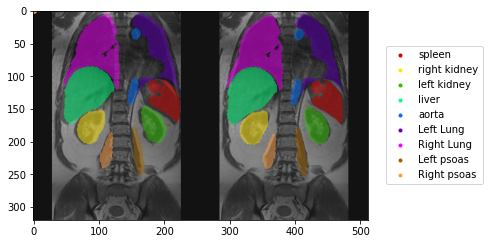

In [ ]:
from tqdm.autonotebook import tqdm

H = 256; W = 320
N = 1000

net = MultimodalNet()
net.cuda()

d0_all = torch.zeros(8,9)
d1_all = torch.zeros(8,9)

nu = 1
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # ...
run_loss = torch.zeros(N)
run_label = torch.zeros(N)
run_dice = torch.zeros(N)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,7000,2)

for i in tqdm(range(N)):
    if((i<(N-8))&(i>8)):
        nu = torch.randperm(8)[0]
    else:
        nu = i%8 #torch.randperm(8)[0]
        
    
    mr_img = (mr_img_all[nu:nu+1,0:1].cuda()-200)/250
    
    ct_in = ct_img_all_reg[nu:nu+1,0:1].cuda()/500
    ct_label_in = F.one_hot(ct_seg_all_reg[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()
    
    # todo: transform input ct image and label map
    ct_img, ct_label = translateMovingImg(ct_in, ct_label_in) # ... 
    
    mr_label = F.one_hot(mr_seg_all[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()
    
    mr_feat,ct_feat = net(mr_img,ct_img)
    
    disp_range = 15 

    # estimate a vector field by callinng your correlation layer
    field = correlationLayer(mr_feat, ct_feat, disp_range) # ...

    t_xy = (field[0:1,:,4:-4,4:-4].mean(-1).mean(-1)/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2)).flip(1)
    t_grid = F.affine_grid(torch.cat((torch.eye(2).cuda(),t_xy.t()),1).unsqueeze(0),(1,1,H,W))
    
    # todo: warp the moving image (CT) and label map (hint: use grid_sample)
    warped_label = F.grid_sample(ct_label_in, grid=t_grid) # ...
    warped_img = F.grid_sample(ct_in, grid=t_grid) # ...

    mask_ = torch.zeros(H,W).cuda()
    mask_[8:-8,8:-8] = 1

    # use the given mask, the fixed MRI and warped CT to estimate mutual information
    loss = mutual_inf(mask_, mr_img, warped_img) # ... 
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    run_loss[i] = loss.item() #(loss0+loss1).item()

    # given: label loss for evaluation only
    loss_label = nn.MSELoss()(mr_label*weight,warped_label*weight)
    run_label[i] = loss_label.item()

    d1 = dice_coeff(mr_label.argmax(1),warped_label.argmax(1).data,10).cpu()

    run_dice[i] = d1.mean()    

    d0 = dice_coeff(mr_label.argmax(1),ct_label.argmax(1),10).cpu()

    d0_all[nu] = d0
    d1_all[nu] = d1
    if(i==7):
        print('initial Dice:',d0_all.mean())
    if(i%200==59):
        print(i,'mi:',run_loss[i-50:i-1].mean(),'label:',run_label[i-50:i-1].mean(),'dice:',run_dice[i-50:i-1].mean(),)

gpu_usage()
rgb = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,ct_label.argmax(1).squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)    
rgb2 = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,warped_label.argmax(1).data.squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)    

plt.imshow(torch.cat((rgb,rgb2),1))
for i in range(1,10):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs_wb[i-1])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

***
## Bonus task

## Bonus 1: Modality Invariant Neighbourhood Descriptor (MIND)
Even though mutual information yields good results to estimate global translations it may cause problems when used to supervise a deformable registration network. Here, we want to implement an extended version of the Modality Invariant Neighbourhood Descriptor (MIND) as metric for learning-based deformable multimodal registration. See https://iplab.dmi.unict.it/miss14/MISS2014-ReadingGroup00-All-Paper.pdf for details if interested. 

![MIND](https://cloud.imi.uni-luebeck.de/s/do5qBKsz6CSaa3S/download)

MIND relies on a pattern of self-similarities in each modality (calculated using patch-distances in the neighbourhood) that are normalised by their local contrast and thus directly comparable across domains. 

The algorithm can be realised in few steps:
- 1) definition of the spatial offset layout of the patch-distances (these are two 1x64x1x2 tensors that are given) and a regular grid with stride 4. It is important that the offset layout remains the same once it has been created.


- 2) the extraction of a local 5x5 patches (padding=2) for every pixel using unfold, the output tensor "img_patch" should be reshaped to contain a channel dimension of C=25 

- 3) the computation of patch-SSDs that define the self-similarities; herefore the grid_sample command has to be applied twice to img_patch using the addition of global (grid) and local (mind_layout1/2) coordinates. Both tensors have to be subtracted, their result squared and summed over the patch-dimension (dim=1). This yields "mind_patch" of shape 1 x 64 x 5120 (H//4 x W//4). 

- 4) afterwards the min value along dim=1 should be subtracted and the result should be devided by the standard deviation along dim=1 (avoid division by zero with small positive constant)

- 5) finally the result should be negated, exponentiated and reshaped to 1 x 64 x H//4 x W//4 and returned

In [ ]:
# smaller fixed length offsets for 64 MIND-SSC like features

# TODO 

def MIND2D(image,mind_layout1,mind_layout2,grid): 
    # TODO
    
    return mind_patch

mind_patch = MIND2D(ct_img_all[:1].cuda(),mind_layout1,mind_layout2,grid)

## Bonus 2: Learning global + local deformable multimodal registration

Now, we are ready to complete the exercise by replacing the MI-loss function with MIND and extending our global only to a combined global and local registration network. We will register two scans by first estimating their translation (with a very large capture range of 19 pixels on the coarse grid), then warp/shift the moving CT image and its corresponding labels; and second estimate a local nonlinear deformation using a smaller capture range of 13 pixels but the same feature network and correlation layer.

You can re-use many elements of the previous task and again use a standard training loop with 1000 Adam-iterations (lr=0.001). The global translation is estimated exactly as before, but now 
- 1) we compute another feature tensor based on the shifted CT image > "ct_feat2" (We again call the forward path of our feature net with fixed MR and shifted/translated CT image). 

- 2) this is used together with "mr_feat" as input to the correlationLayer with disp_range = 13. Now we want to estimate a deformable transformation. 

- 3) to regularise the field that the correlationLayer estimates, we apply two avg_pool2d with kernel=5, stride=1 and padding=2 and interpolate the result by a scale_factor=8 with mode='bilinear'. Afterwards the displacements need to be converted into pytorch's defintion using
```smooth_disp = (smooth_field/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2,1,1)).flip(1)```

- 4) we use grid_sample with "ct_mind" as first and the addition of previous translation grid "t_grid" and smooth_disp to warp the MIND features (note that the stride of MIND is 4). 

- 5) we use ```nn.SmoothL1Loss(beta=.25)``` https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html?highlight=nn%20smoothl1loss#torch.nn.SmoothL1Loss as loss function between "mr_mind" and the warped ct_mind

- 6) complete the training loop with loss.backward(), optimizer.step() and optimizer.zero_grad()

The model should train without approx. 1 minute and yield an average Dice overlap of 68-71% up from just 36% initial alignment. We provided some functions to visualise the output

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


iter: 49, loss: 0.208, init Dice: 36.29, current Dice: 36.296, runtime: 11.197 sec
iter: 99, loss: 0.213, init Dice: 36.29, current Dice: 47.662, runtime: 22.051 sec
iter: 149, loss: 0.199, init Dice: 36.29, current Dice: 51.372, runtime: 32.984 sec
iter: 199, loss: 0.191, init Dice: 36.29, current Dice: 54.511, runtime: 43.896 sec
iter: 249, loss: 0.194, init Dice: 36.29, current Dice: 58.920, runtime: 54.813 sec
iter: 299, loss: 0.184, init Dice: 36.29, current Dice: 57.345, runtime: 65.729 sec
iter: 349, loss: 0.187, init Dice: 36.29, current Dice: 52.018, runtime: 76.629 sec
iter: 399, loss: 0.185, init Dice: 36.29, current Dice: 58.419, runtime: 87.537 sec
iter: 449, loss: 0.184, init Dice: 36.29, current Dice: 64.617, runtime: 98.409 sec
iter: 499, loss: 0.182, init Dice: 36.29, current Dice: 60.621, runtime: 109.317 sec
iter: 549, loss: 0.180, init Dice: 36.29, current Dice: 64.807, runtime: 120.199 sec
iter: 599, loss: 0.179, init Dice: 36.29, current Dice: 63.052, runtime: 131

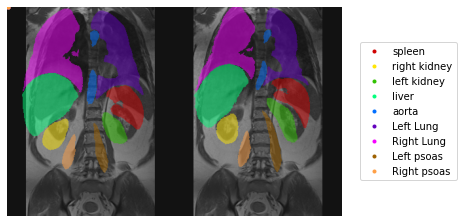

In [ ]:
## setup given up until the image/label samples are pre-processed
import time
from tqdm.autonotebook import tqdm
H = 256; W = 320

n_epochs = 1000

net = FeatureNet()
net.cuda()

d0_all = torch.zeros(8,9)
d1_all = torch.zeros(8,9)

optimizer = # ... 
run_loss = torch.zeros(n_epochs)
run_dice = torch.zeros(n_epochs)

t0 = time.time()

for i in tqdm(range(n_epochs)):
    if((i<(n_epochs-8))&(i>8)):
        nu = torch.randperm(8)[0]
    else:
        nu = i%8
        
    mr_img = (mr_img_all[nu:nu+1,0:1].cuda()-200)/250
    ct_img = ct_img_all[nu:nu+1,0:1].cuda()/500
    mr_label = F.one_hot(mr_seg_all[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()
    ct_label = F.one_hot(ct_seg_all[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()
    
    # TODO call feature net, call MIND2D with no_grad(), call correlationLayer (using a disparity range of 19) 
    # and estimate translation
    # Please store MIND features for MRI and CT in mr_mind and ct_mind respectively

    # ...


    t_xy = (field[0:1,:,4:-4,4:-4].mean(-1).mean(-1)/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2)).flip(1)
    t_grid = F.affine_grid(torch.cat((torch.eye(2).cuda(),t_xy.t()),1).unsqueeze(0),(1,1,H,W))

    # todo: warp the moving image (CT) and label map (hint: use grid_sample)
    ct_img2 = # ...
    ct_label2 = # ...

    # TODO call feature net again and MIND2D for shifted CT, call correlationLayer and smooth/interpolate field
    #convert field to pytorch displacements, warp image, label (take care to include t_grid) and MIND (stride=4!)
    #call SmoothL1Loss (x4), and backward, step, zero_grad (disparity range: 13).
    # Please store the MIND features in ct_mind2

    # ...


    field = # ...


    smooth_field = # 

    smooth_disp = # 

    # TODO 
    grid0 = F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H,W))
    warped_label = # ... 
    warped_img = # ... 
    warped_mind = # ...

    loss = # 
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    run_loss[i] = loss.item()
    
    ## end TODO
    
    #given: evaluation, logging  
    d1 = dice_coeff(mr_label.argmax(1),warped_label.argmax(1).data,10).cpu()

    run_dice[i] = d1.mean()    

    d1_all[nu] = d1
    if(i<=7):
        d0 = dice_coeff(mr_label.argmax(1),ct_label.argmax(1),10).cpu()
        d0_all[nu] = d0
        
    
    if(i%50==49):
        str1 = f"iter: {i}, loss: {'%0.3f'%run_loss[i-20:i-1].mean()}, init Dice: {'%0.2f'%(100*d0_all.mean())}, current Dice: {'%0.3f'%(100*run_dice[i-20:i-1].mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec"
        tqdm.write(str1)
        
        

#given visualisation of overlay before after
gpu_usage()
rgb = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,ct_label.argmax(1).squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)    
rgb2 = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,warped_label.argmax(1).data.squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)    

plt.imshow(torch.cat((rgb,rgb2),1))
plt.axis('off')
for i in range(1,10):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs_wb[i-1])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

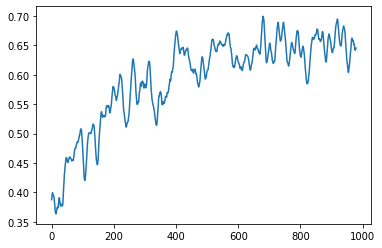

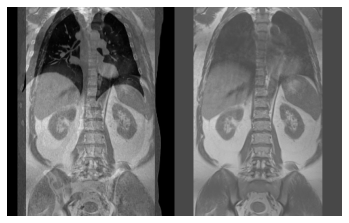

gpu usage (current/max): 0.03 / 2.07 GB
Dice before 36.29 and after 64.97


In [ ]:
plt.plot(F.avg_pool1d(F.avg_pool1d(run_dice.view(1,1,-1),11,stride=1),11,stride=1).squeeze())
plt.show()
overlay_before = torch.clamp(mr_img_all[nu,0].data.permute(1,0).flip(0,1),0,700)/300+\
           torch.clamp(ct_img_all[nu,0].data.permute(1,0).flip(0,1)+800,0,1200)/1200

overlay_after = torch.clamp(mr_img_all[nu,0].data.permute(1,0).flip(0,1),0,700)/300+\
           torch.clamp(warped_img.cpu().data.squeeze().permute(1,0).flip(0,1)*500+800,0,1200)/1200


plt.imshow(torch.cat((overlay_before,overlay_after),1),'gray')
plt.axis('off')
plt.show()

gpu_usage()
print('Dice before','%0.2f'%(100*d0_all.mean()),'and after','%0.2f'%(100*d1_all.mean()))

In [ ]:
gpu_usage()
print(d0_all.mean(),d1_all.mean())

gpu usage (current/max): 0.03 / 2.07 GB
tensor(0.3629) tensor(0.6497)


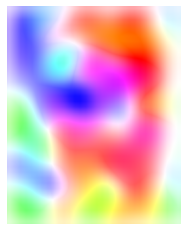

In [ ]:
rgb = showFlow(smooth_disp.data.cpu())
plt.imshow(np.flip(rgb.transpose(1,0,2),0))
plt.axis('off')
plt.show()